# Import packages

In [730]:
import requests
import json
import pandas as pd
import numpy as np
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import pickle
import geopandas as gpd


from datetime import date, timedelta
import covidcast

from sklearn.pipeline import Pipeline 
from sklearn.impute import KNNImputer, SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

# Import Data

In [731]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv'
s = requests.get(url).text
nymask = pd.read_csv(StringIO(s))

In [732]:
nymask.COUNTYFP = nymask.COUNTYFP.astype(str)
nymask.COUNTYFP = np.where(nymask['COUNTYFP'].str.len() == 4, '0' + nymask.COUNTYFP, nymask.COUNTYFP)
nymask.COUNTYFP = nymask.COUNTYFP.astype(int)
nymask.columns = ['FIPS', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']

In [733]:
# create variable to hold date object for two days ago
two_days_ago = date.today() - timedelta(days=2)

In [734]:
# get the most recent survey data
mask_ind = covidcast.signal("fb-survey", "smoothed_wearing_mask",
                            date(2020, 10, 1), two_days_ago,
                            "county")
mask_oth = covidcast.signal('fb-survey', 'smoothed_others_masked', 
                            date(2020, 11, 24),two_days_ago, 
                            "county")

In [735]:
# remove data that isn't at the county level
mask_fip = mask_ind.loc[~mask_ind.geo_value.str.endswith('000')]
mask_oth = mask_oth.loc[~mask_oth.geo_value.str.endswith('000')]

In [736]:
# check number of counties represented 
print(mask_ind.geo_value.value_counts().shape)
print(mask_fip.geo_value.value_counts().shape)
mask_oth.geo_value.value_counts().shape

(723,)
(674,)


(653,)

In [737]:
# pare down datasets to just columns of interest
mask_ind_means = pd.DataFrame(mask_fip.groupby(['geo_value'])['value'].mean()).reset_index()
mask_ind_means.columns = ['FIPS', 'ind_mask']
mask_ind_means['FIPS'] = mask_ind_means['FIPS'].astype(int)
# repeat for other survey
mask_oth_means = pd.DataFrame(mask_oth.groupby(['geo_value'])['value'].mean()).reset_index()
mask_oth_means.columns = ['FIPS', 'oth_mask']
mask_oth_means['FIPS'] = mask_oth_means['FIPS'].astype(int)

In [738]:
mask_means = mask_ind_means.merge(mask_oth_means, on = 'FIPS', how = 'outer')
mask_w_nyt = mask_means.merge(nymask, on = 'FIPS', how = 'outer')

In [739]:
election = pd.read_csv('data/county_statistics.csv', index_col="Unnamed: 0")

In [740]:
election = election[election.county != 'Unassigned']
election['county'] = election['county'] + ', ' + election['state']
# election.drop(['state'], axis=1, inplace=True)

In [741]:
to_keep = ['county', 'total_votes20' , 'percentage20_Joe_Biden']
election = election.dropna(subset=['votes20_Joe_Biden'])

In [742]:
merge_elec = election[to_keep]

In [743]:
print(merge_elec.shape)
# election.columns

(4633, 3)


In [744]:
rural_urban = pd.read_excel('data/ru_code.xls')
fip_rur = rural_urban[['FIPS', 'RUCC_2013']]

In [745]:
geo = gpd.read_file('https://opendata.arcgis.com/datasets/4cb598ae041348fb92270f102a6783cb_0.geojson')

In [746]:
geo = geo[~geo.Countyname.str.contains("Out of")]
geo = geo[~geo.Countyname.str.contains("Unassigned")]
geo = geo[~geo.ST_Name.str.contains("Puerto Rico")]
geo.drop(geo.tail(7).index, inplace=True)
geo['FIPS'] = geo.FIPS.astype('int64')

In [747]:
# prelim feature engineering
geo['Staf_Bed_Perc'] = geo['Beds_Staff'] / geo['Beds_Licen']
geo['Aged_Perc'] = geo.AgedPop / geo.POP_ESTIMA
geo['Pov_Perc'] = geo.POVALL_201 / geo.POP_ESTIMA
geo['beds_per_capita'] = geo.Beds_ICU / geo.POP_ESTIMA
geo['pop_density'] = geo['TotalPop'] / geo['Shape__Area']
geo['county'] = geo['Countyname'] + ', ' + geo['ST_Abbr']
# drop unneeded columns
geo.drop(columns=['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 
                  'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 
                  'Day_11', 'Day_12', 'Day_13', 'Day_14', 
                  'OBJECTID', 'ST_ID', 'PCTPOVALL_', 'Med_HH_Inc', 
                  'State_Fata', 'DateChecke', 'url', 'Thumbnail', 
                  'State_Conf', 'State_Deat', 'State_Reco', 'State_Test', 
                  'POP_ESTIMA', 'NonHispWhP', 'BlackPop', 'AmIndop', 'PacIslPop', 
                  'OtherPop', 'TwoMorPop', 'HispPop', 'NonHisp', 'Age_85', 
                  'Age_80_84', 'Age_75_79', 'Age_70_74', 'Age_65_69', 
                  'Agetotal', 'AsianPop', 'Countyname', 'ST_Name',
                  'Age_Less15', 'Age_15_24', 'Age_25_34', 'Age_35_64', 
                  'Age_65_74', 'Confirmed', 'Deaths', 'Unemployed', 'Beds_Licen', 
                  'Beds_Staff', 'Ventilator', 'Unemployed', 'Beds_ICU', 'AgedPop',
                  'Wh_Alone', 'Bk_Alone', 'AI_Alone', 'As_Alone', 'NH_Alone', 'SO_Alone', 
                  'Two_More', 'Not_Hisp', 'Age_Over75'], 
            inplace=True)

In [748]:
geo.drop(columns=['Recovered', 'Active'], inplace=True)
geo.drop(columns=['EM_notes'], inplace=True)
geo.EM_date = geo.EM_date.str.extract(r'((\d+)\/(\d{2})\/(\d{4}))')
geo.EM_type = geo.EM_type.replace({'Govt Ordered Community Quarantine': 'CQ', 'Govt Directed Social Distancing': 'SD'})

In [749]:
fip_rur.shape

(3234, 2)

In [750]:
geo = geo.merge(fip_rur, how = 'left', on = 'FIPS')

In [751]:
merge1 = geo.merge(mask_w_nyt, how = 'left', on = 'FIPS')
non_impute = merge1.merge(merge_elec, on = 'county',how='left', sort=True)

In [752]:
merge1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ST_Abbr          3142 non-null   object  
 1   FIPS             3142 non-null   int64   
 2   FatalityRa       3142 non-null   float64 
 3   Confirmedb       3142 non-null   float64 
 4   DeathsbyPo       3142 non-null   float64 
 5   Unemployme       3142 non-null   float64 
 6   EM_type          3142 non-null   object  
 7   EM_date          2515 non-null   object  
 8   POVALL_201       3142 non-null   int64   
 9   Median_Hou       3142 non-null   int64   
 10  NewCases         3142 non-null   int64   
 11  NewDeaths        3142 non-null   int64   
 12  TotalPop         3142 non-null   int64   
 13  NewCasebyP       3142 non-null   float64 
 14  Inpat_Occ        2423 non-null   float64 
 15  ICU_Occ          1552 non-null   float64 
 16  Shape__Area      3142 non-null   f

In [753]:
impute_df = merge1[['TotalPop', 'Median_Hou', 'RUCC_2013', 'ind_mask', 'oth_mask', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
# impute_df['RUCC_2013'].astype(str)

In [754]:
scaler = StandardScaler()
impute_df = pd.DataFrame(scaler.fit_transform(impute_df), columns = impute_df.columns)
impute_df

,TotalPop,Median_Hou,RUCC_2013,ind_mask,oth_mask,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,-0.144214,0.471712,-1.110479,NaN,NaN,-0.460280,-0.160825,0.218651,1.373096,-0.421207
1,0.319343,0.345882,-0.741182,-2.478655,-2.447332,0.052290,-0.431315,-0.402024,1.813618,-0.473781
2,-0.233399,-1.322700,0.366710,NaN,NaN,-0.221080,0.686710,-0.022723,-0.105799,-0.112335
3,-0.243267,-0.482729,-1.479776,NaN,NaN,-1.024106,-0.882131,-0.436506,1.105636,0.419977
4,-0.136802,-0.170095,-1.479776,NaN,NaN,-0.460280,0.560482,1.011736,-0.215930,-0.322631
...,...,...,...,...,...,...,...,...,...,...
3137,-0.177814,1.476700,-0.002587,NaN,NaN,-0.323594,3.824394,1.873784,-0.971110,-1.577836
3138,-0.241654,3.329785,0.736007,NaN,NaN,0.257318,1.335886,0.666916,0.617915,-1.104669
3139,-0.249082,0.763854,0.736007,NaN,NaN,0.308575,3.517839,0.563470,-0.011402,-1.604123
3140,-0.286916,0.173458,0.736007,NaN,NaN,2.119654,1.299821,-0.902012,1.215766,-1.452972


In [755]:
knn_imputer = KNNImputer(n_neighbors=5, weights = 'distance')
simple_imputer = SimpleImputer()

In [756]:
imputed = knn_imputer.fit_transform(impute_df)
# imputed = simple_imputer.fit_transform(impute_df)

In [757]:
mask_imputed = pd.DataFrame(imputed, columns = impute_df.columns)['ind_mask']

In [758]:
merge1['ind_mask'] = mask_imputed

In [759]:
elec_geo_df = merge1.merge(merge_elec, on = 'county',how='left', sort=True)
# elec_geo_df = elec_geo_df.merge(mask_ind_means, how = 'left', on = 'FIPS')
elec_geo_df.percentage20_Joe_Biden.isna().sum()

94

In [760]:
elec_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ST_Abbr                 3142 non-null   object  
 1   FIPS                    3142 non-null   int64   
 2   FatalityRa              3142 non-null   float64 
 3   Confirmedb              3142 non-null   float64 
 4   DeathsbyPo              3142 non-null   float64 
 5   Unemployme              3142 non-null   float64 
 6   EM_type                 3142 non-null   object  
 7   EM_date                 2515 non-null   object  
 8   POVALL_201              3142 non-null   int64   
 9   Median_Hou              3142 non-null   int64   
 10  NewCases                3142 non-null   int64   
 11  NewDeaths               3142 non-null   int64   
 12  TotalPop                3142 non-null   int64   
 13  NewCasebyP              3142 non-null   float64 
 14  Inpat_Occ       

In [761]:
scaler2 = StandardScaler()
non_impute = pd.DataFrame(scaler2.fit_transform(non_impute[['percentage20_Joe_Biden', 'ind_mask']]), columns = ['percentage20_Joe_Biden', 'ind_mask'])


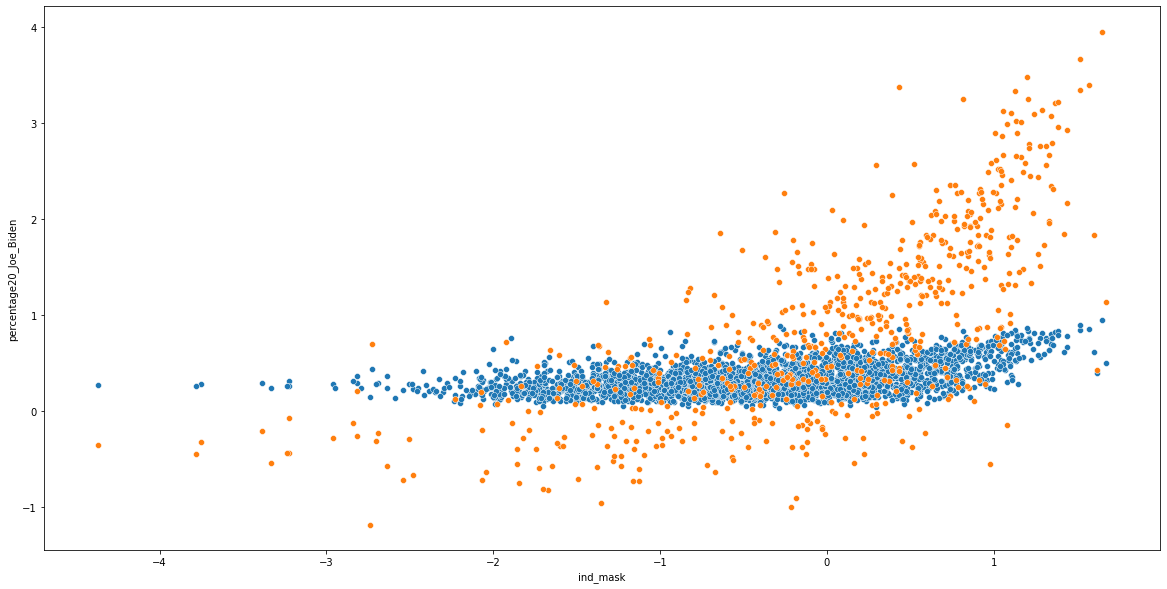

In [762]:
plt.figure(figsize = (20,10))
sns.scatterplot(x=elec_geo_df['ind_mask'], y = elec_geo_df['percentage20_Joe_Biden'])
sns.scatterplot(x=non_impute['ind_mask'], y = non_impute['percentage20_Joe_Biden'])

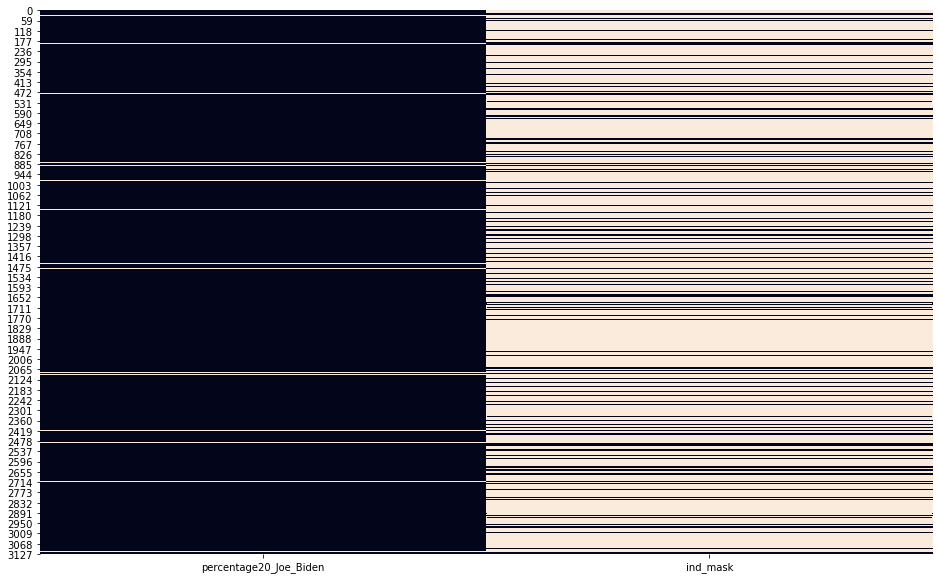

In [763]:
plt.figure(figsize = (16,10))
sns.heatmap(non_impute.isna(), cbar=False)

In [764]:
# elec_geo_df.to_file('data/elec.geojson', driver='GeoJSON')

# Modeling Process